In [63]:
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Activation
from tensorflow.keras import Model
from tensorflow.keras.callbacks import Callback
import matplotlib.pyplot as plt
import numpy as np

# **Построение и обучение модели для выполнения функции логического "Исключающего ИЛИ" (XOR)** 

In [64]:
X = tf.constant([[0, 0], [0, 1], [1, 0], [1, 1]], dtype=tf.float32) # входные данные x1 и x2 (признаки, характеризующие объект)
Y = tf.constant([[0], [1], [1], [0]], dtype=tf.float32) # желаемый выход (метки классов для каждого объекта)

In [65]:
# Вспомогательная функция для отрисовки границы решения
def plot_decision_boundary(model, X, y):

  # Определются границы рассматриваемого пространства (минимальный и максимальный x и y) и создаётся его сетка meshgrid
  X = X.numpy()
  y = y.numpy()
  x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
  y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
  xx1, xx2 = np.meshgrid(np.linspace(x_min, x_max, 500),
                         np.linspace(y_min, y_max, 500))

  # Создаются входные сигналы X (мы собираемся предсказывать значения по всей сетке рассматриваемого пространства)
  x_in = np.c_[xx1.ravel(), xx2.ravel()] # соединяем 2D массивы вместе: https://numpy.org/devdocs/reference/generated/numpy.c_.html

  # Осуществляется предсказание для входных сигналов X
  y_pred = model.predict(x_in, batch_size=1024)
  y_pred = np.round(np.max(y_pred, axis=-1)).reshape(xx1.shape) # reshape необходим поскольку результатом будет 1D вектор, а необходим 2D, как у xx1

  # Визуализация границ решения
  plt.contourf(xx1, xx2, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
  plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
  plt.xlabel("x1")
  plt.ylabel("x2")
  plt.pause(0.01)

# Вспомогательный колбэк для отрисовки границы решений каждые 100 эпох и остановки обучения если точность достигла 1.0
class PlotAndStopCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % 100 == 0:  # Отрисовываем каждые 100 эпох
            print(f"Epoch {epoch + 1}")
            plot_decision_boundary(self.model, X, Y)

        if logs.get('accuracy') == 1.0:  # Остановка, если точность достигла 1.0
            print(f"\nStopping training at epoch {epoch + 1} as accuracy reached 1.0")
            plot_decision_boundary(self.model, X, Y)
            self.model.stop_training = True

In [66]:
###### Основной код ######

def createModel(input_shape):
  input_x = Input(shape=(input_shape, )) # для создания модели необходимо предопределить вход и размерность входных данных input_shape
  z1 = Dense(2)(input_x) # создаём 1 нейрон и передаём в него входные сигналы input_x
  act1 = Activation('tanh')(z1)
  z2 = Dense(1)(act1)
  p = Activation('sigmoid')(z2) # результат обработки нейроном входных сигналов z поступает в сигмоидальную функцию активации, которая выдаёт вероятность принадлежности к классу 1
  return Model(inputs=input_x, outputs=p) # создаём модель, задавая вход и выход и возвращаем эту модель для последующих манипуляций

def trainModel(X, Y): 
  model = createModel(2) # создаётся модель принимающая на вход входные сигналы с размерностью 2
  #  Компилируется модель, задаётся оптимизатор sgd - стохастический градиентный спуск (алгоритм минимизирующий функцию ошибки), можно ещё попробовать: adam, rmsprop
  #                       задаётся функция ошибки loss бинарная кроссэнтропия для задачи бинарной классификации (0 или 1)
  #                       задаётся метрика Accuracy - точность. Формула: отношение правильных предсказаний на общее количество предсказаний
  model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])
  model.summary() # вывод информации о созданной модели
  callback = PlotAndStopCallback() # используем колбэк для отрисовки
  model.fit(x=X, y=Y, epochs=10000, callbacks=[callback]) # вызывается метод обучения, принимающий на вход X, Y и количество эпох обучения
  return model # обученная модель возвращается для тестирования и других манипуляций

def testModel(X_test, model):
  result = model.predict(X_test) # вызывается метод предсказания для входных тестовых данных
  print(result)
  # Задаётся решающее правило.
  if(result >= 0.5): # если выходная вероятность предсказания больше или равно 0.5 то возвращаем класс 1
    return 1
  elif(result < 0.5): # если выходная вероятность предсказания меньше 0.5 то возвращаем класс 0
    return 0

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 2)              │             6 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_19 (Activation)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_20 (Activation)      │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9 (36.00 B)

 Trainable params: 9 (36.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - accuracy: 0.7500 - loss: 0.7822
Epoch 2/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7500 - loss: 0.7819
Epoch 3/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7500 - loss: 0.7816
Epoch 4/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7500 - loss: 0.7813
Epoch 5/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7500 - loss: 0.7810
Epoch 6/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7500 - loss: 0.7807
Epoch 7/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7500 - loss: 0.7804
Epoch 8/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7500 - loss: 0.7801
Epoch 9/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7500 - loss: 0.7798
Epoch 10/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7500 - loss: 0.7796
Epoch 11/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7500 - loss: 0.7793
Epoch 12/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/ste

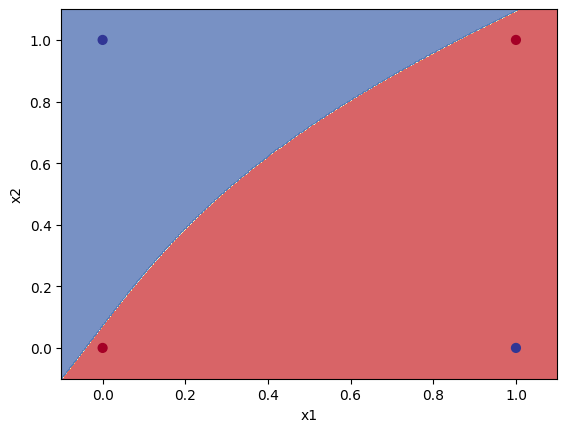

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - accuracy: 0.7500 - loss: 0.7555
Epoch 101/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.7500 - loss: 0.7553
Epoch 102/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7500 - loss: 0.7550
Epoch 103/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7500 - loss: 0.7548
Epoch 104/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7500 - loss: 0.7545
Epoch 105/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7500 - loss: 0.7543
Epoch 106/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7500 - loss: 0.7540
Epoch 107/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7500 - loss: 0.7538
Epoch 108/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7500 - loss: 0.7535
Epoch 109/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7500 - loss: 0.7533
Epoch 110/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7500 - loss: 0.7531
Epoch 111/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23

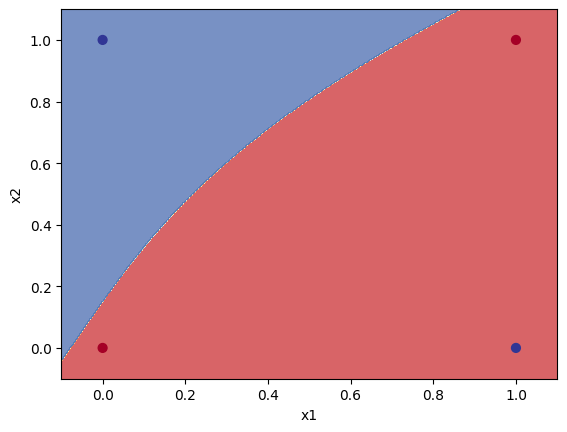

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - accuracy: 0.7500 - loss: 0.7329
Epoch 201/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7500 - loss: 0.7327
Epoch 202/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7500 - loss: 0.7325
Epoch 203/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7500 - loss: 0.7322
Epoch 204/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7500 - loss: 0.7320
Epoch 205/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7500 - loss: 0.7318
Epoch 206/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7500 - loss: 0.7316
Epoch 207/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7500 - loss: 0.7314
Epoch 208/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7500 - loss: 0.7312
Epoch 209/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7500 - loss: 0.7310
Epoch 210/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7500 - loss: 0.7308
Epoch 211/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15m

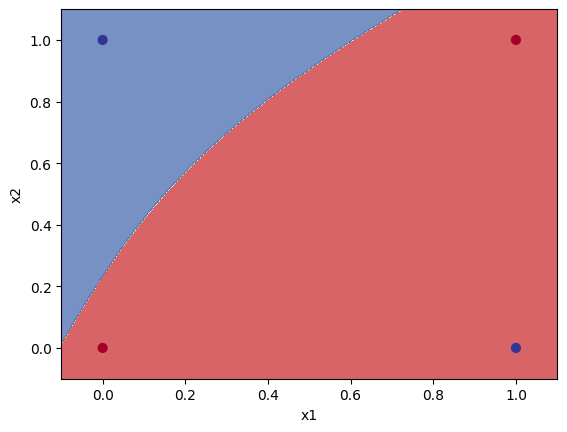

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - accuracy: 0.7500 - loss: 0.7137
Epoch 301/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7500 - loss: 0.7135
Epoch 302/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7500 - loss: 0.7133
Epoch 303/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7500 - loss: 0.7131
Epoch 304/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7500 - loss: 0.7130
Epoch 305/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7500 - loss: 0.7128
Epoch 306/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7500 - loss: 0.7126
Epoch 307/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7500 - loss: 0.7124
Epoch 308/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7500 - loss: 0.7123
Epoch 309/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7500 - loss: 0.7121
Epoch 310/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7500 - loss: 0.7119
Epoch 311/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18m

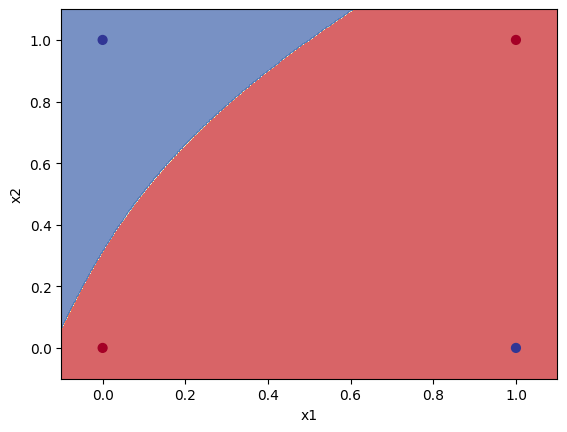

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.7500 - loss: 0.6975
Epoch 401/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7500 - loss: 0.6974
Epoch 402/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7500 - loss: 0.6972
Epoch 403/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7500 - loss: 0.6971
Epoch 404/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7500 - loss: 0.6969
Epoch 405/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7500 - loss: 0.6968
Epoch 406/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7500 - loss: 0.6966
Epoch 407/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7500 - loss: 0.6965
Epoch 408/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7500 - loss: 0.6963
Epoch 409/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7500 - loss: 0.6962
Epoch 410/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7500 - loss: 0.6960
Epoch 411/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17m

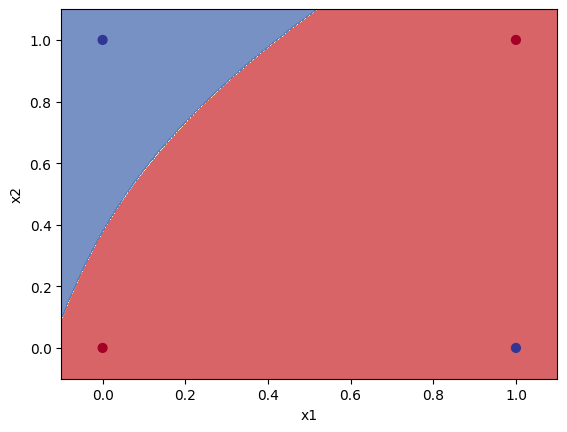

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - accuracy: 0.7500 - loss: 0.6841
Epoch 501/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7500 - loss: 0.6839
Epoch 502/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7500 - loss: 0.6838
Epoch 503/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7500 - loss: 0.6837
Epoch 504/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7500 - loss: 0.6836
Epoch 505/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7500 - loss: 0.6834
Epoch 506/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7500 - loss: 0.6833
Epoch 507/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7500 - loss: 0.6832
Epoch 508/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7500 - loss: 0.6831
Epoch 509/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7500 - loss: 0.6830
Epoch 510/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7500 - loss: 0.6828
Epoch 511/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15m

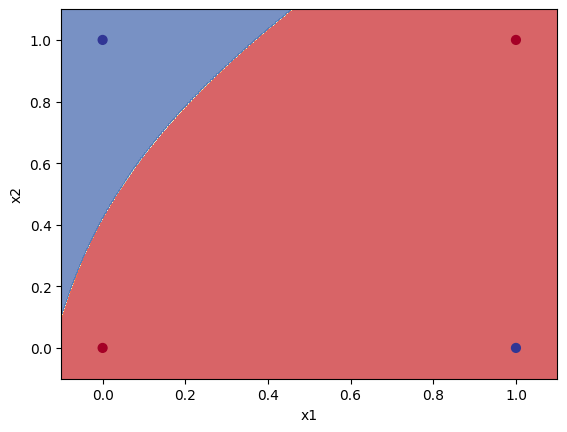

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - accuracy: 0.7500 - loss: 0.6729
Epoch 601/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7500 - loss: 0.6728
Epoch 602/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7500 - loss: 0.6727
Epoch 603/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7500 - loss: 0.6726
Epoch 604/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7500 - loss: 0.6725
Epoch 605/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7500 - loss: 0.6724
Epoch 606/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7500 - loss: 0.6723
Epoch 607/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7500 - loss: 0.6722
Epoch 608/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7500 - loss: 0.6721
Epoch 609/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7500 - loss: 0.6720
Epoch 610/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7500 - loss: 0.6719
Epoch 611/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21m

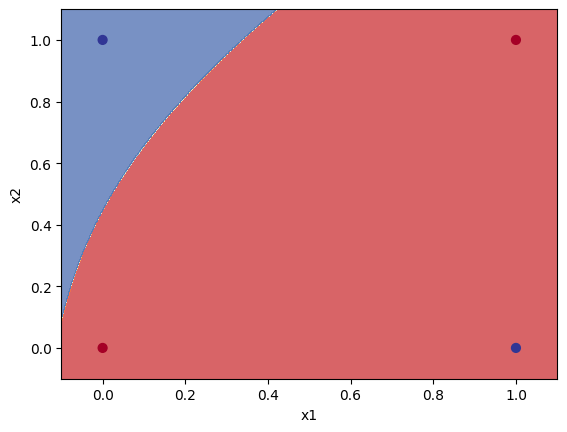

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.7500 - loss: 0.6634
Epoch 701/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7500 - loss: 0.6633
Epoch 702/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7500 - loss: 0.6632
Epoch 703/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7500 - loss: 0.6631
Epoch 704/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7500 - loss: 0.6630
Epoch 705/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7500 - loss: 0.6629
Epoch 706/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7500 - loss: 0.6628
Epoch 707/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7500 - loss: 0.6628
Epoch 708/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7500 - loss: 0.6627
Epoch 709/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7500 - loss: 0.6626
Epoch 710/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7500 - loss: 0.6625
Epoch 711/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22m

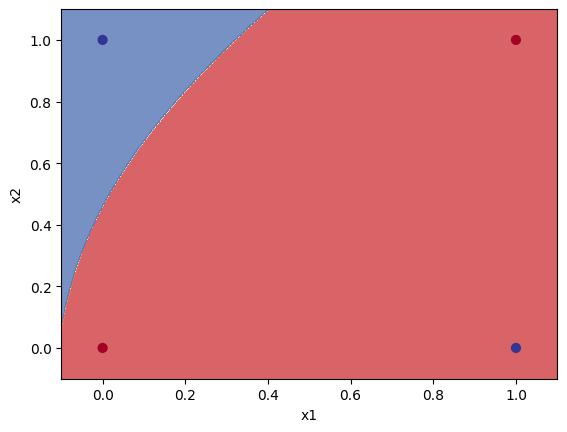

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.7500 - loss: 0.6550
Epoch 801/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7500 - loss: 0.6549
Epoch 802/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7500 - loss: 0.6548
Epoch 803/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7500 - loss: 0.6547
Epoch 804/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.7500 - loss: 0.6546
Epoch 805/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7500 - loss: 0.6546
Epoch 806/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7500 - loss: 0.6545
Epoch 807/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7500 - loss: 0.6544
Epoch 808/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7500 - loss: 0.6543
Epoch 809/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7500 - loss: 0.6542
Epoch 810/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7500 - loss: 0.6542
Epoch 811/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18m

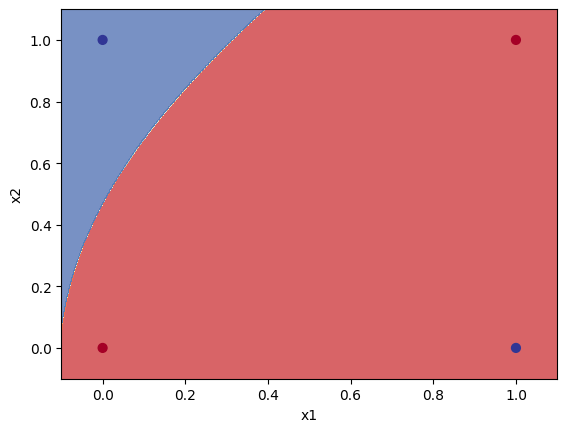

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - accuracy: 0.7500 - loss: 0.6472
Epoch 901/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7500 - loss: 0.6471
Epoch 902/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7500 - loss: 0.6470
Epoch 903/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7500 - loss: 0.6469
Epoch 904/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7500 - loss: 0.6469
Epoch 905/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7500 - loss: 0.6468
Epoch 906/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7500 - loss: 0.6467
Epoch 907/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7500 - loss: 0.6466
Epoch 908/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7500 - loss: 0.6466
Epoch 909/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7500 - loss: 0.6465
Epoch 910/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7500 - loss: 0.6464
Epoch 911/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17m

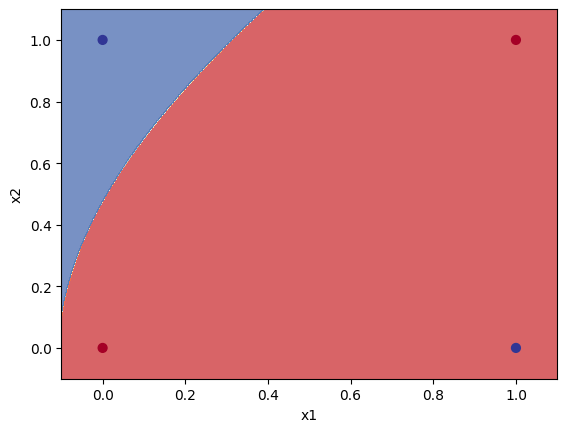

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step - accuracy: 0.7500 - loss: 0.6396
Epoch 1001/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7500 - loss: 0.6395
Epoch 1002/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7500 - loss: 0.6394
Epoch 1003/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7500 - loss: 0.6393
Epoch 1004/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7500 - loss: 0.6393
Epoch 1005/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7500 - loss: 0.6392
Epoch 1006/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7500 - loss: 0.6391
Epoch 1007/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7500 - loss: 0.6390
Epoch 1008/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7500 - loss: 0.6390
Epoch 1009/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7500 - loss: 0.6389
Epoch 1010/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7500 - loss: 0.6388
Epoch 1011/10000
1/1 ━━━━━━━━━━━━━━━━

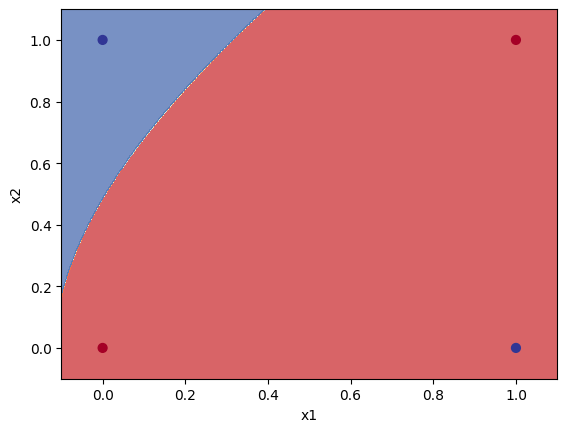

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - accuracy: 0.7500 - loss: 0.6319
Epoch 1101/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7500 - loss: 0.6318
Epoch 1102/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7500 - loss: 0.6318
Epoch 1103/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7500 - loss: 0.6317
Epoch 1104/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7500 - loss: 0.6316
Epoch 1105/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7500 - loss: 0.6315
Epoch 1106/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7500 - loss: 0.6314
Epoch 1107/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7500 - loss: 0.6314
Epoch 1108/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7500 - loss: 0.6313
Epoch 1109/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7500 - loss: 0.6312
Epoch 1110/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7500 - loss: 0.6311
Epoch 1111/10000
1/1 ━━━━━━━━━━━━━━━━

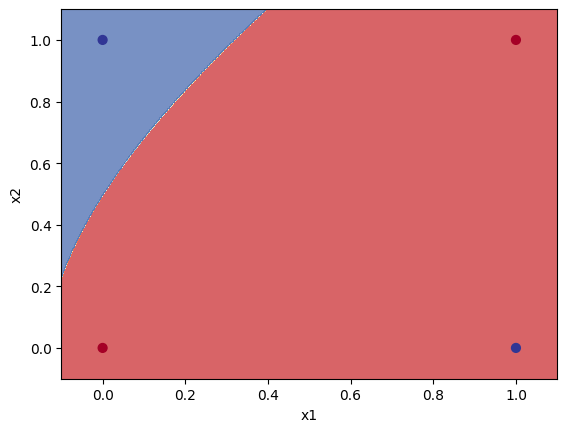

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.7500 - loss: 0.6240
Epoch 1201/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7500 - loss: 0.6239
Epoch 1202/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7500 - loss: 0.6238
Epoch 1203/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7500 - loss: 0.6237
Epoch 1204/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7500 - loss: 0.6236
Epoch 1205/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7500 - loss: 0.6236
Epoch 1206/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7500 - loss: 0.6235
Epoch 1207/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7500 - loss: 0.6234
Epoch 1208/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7500 - loss: 0.6233
Epoch 1209/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7500 - loss: 0.6232
Epoch 1210/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7500 - loss: 0.6232
Epoch 1211/10000
1/1 ━━━━━━━━━━━━━━━━

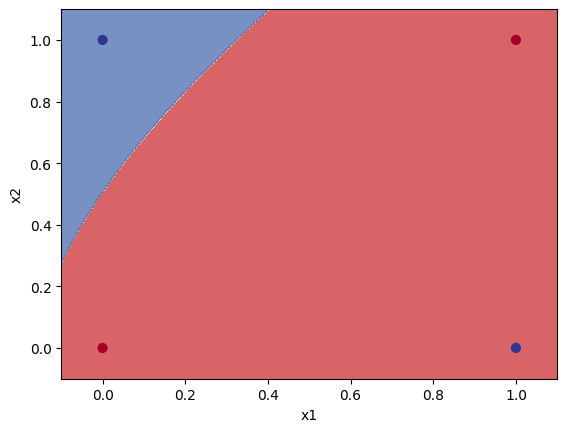

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.7500 - loss: 0.6156
Epoch 1301/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7500 - loss: 0.6155
Epoch 1302/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7500 - loss: 0.6154
Epoch 1303/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7500 - loss: 0.6153
Epoch 1304/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7500 - loss: 0.6153
Epoch 1305/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7500 - loss: 0.6152
Epoch 1306/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7500 - loss: 0.6151
Epoch 1307/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7500 - loss: 0.6150
Epoch 1308/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7500 - loss: 0.6149
Epoch 1309/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7500 - loss: 0.6148
Epoch 1310/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7500 - loss: 0.6147
Epoch 1311/10000
1/1 ━━━━━━━━━━━━━━━━

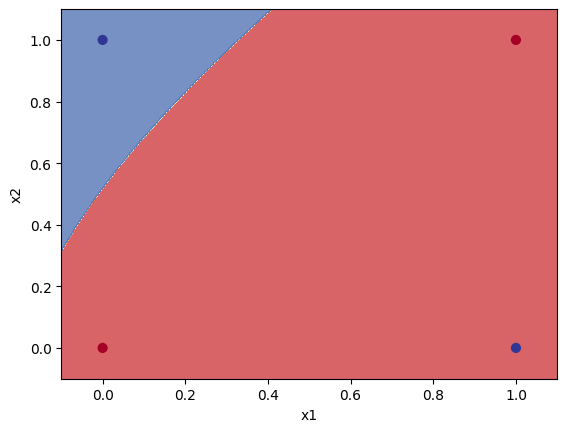

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - accuracy: 0.7500 - loss: 0.6067
Epoch 1401/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7500 - loss: 0.6066
Epoch 1402/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7500 - loss: 0.6065
Epoch 1403/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7500 - loss: 0.6064
Epoch 1404/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7500 - loss: 0.6063
Epoch 1405/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.7500 - loss: 0.6062
Epoch 1406/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7500 - loss: 0.6061
Epoch 1407/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7500 - loss: 0.6060
Epoch 1408/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7500 - loss: 0.6060
Epoch 1409/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7500 - loss: 0.6059
Epoch 1410/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7500 - loss: 0.6058
Epoch 1411/10000
1/1 ━━━━━━━━━━━━━━━━

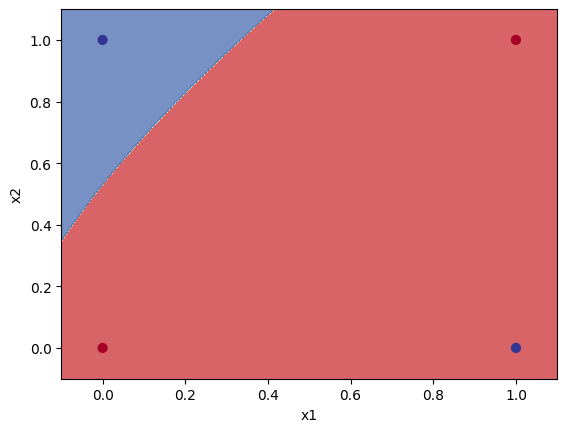

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - accuracy: 0.7500 - loss: 0.5972
Epoch 1501/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7500 - loss: 0.5971
Epoch 1502/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7500 - loss: 0.5970
Epoch 1503/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7500 - loss: 0.5969
Epoch 1504/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7500 - loss: 0.5968
Epoch 1505/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7500 - loss: 0.5967
Epoch 1506/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7500 - loss: 0.5966
Epoch 1507/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7500 - loss: 0.5965
Epoch 1508/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7500 - loss: 0.5964
Epoch 1509/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7500 - loss: 0.5963
Epoch 1510/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7500 - loss: 0.5962
Epoch 1511/10000
1/1 ━━━━━━━━━━━━━━━━

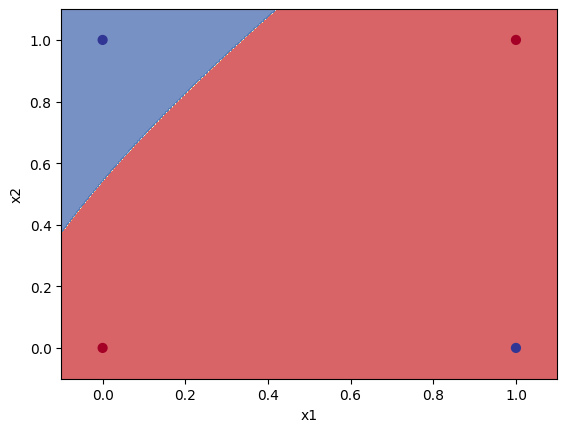

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step - accuracy: 0.7500 - loss: 0.5869
Epoch 1601/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7500 - loss: 0.5868
Epoch 1602/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7500 - loss: 0.5867
Epoch 1603/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7500 - loss: 0.5866
Epoch 1604/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7500 - loss: 0.5865
Epoch 1605/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7500 - loss: 0.5864
Epoch 1606/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7500 - loss: 0.5863
Epoch 1607/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7500 - loss: 0.5862
Epoch 1608/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7500 - loss: 0.5861
Epoch 1609/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7500 - loss: 0.5860
Epoch 1610/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7500 - loss: 0.5859
Epoch 1611/10000
1/1 ━━━━━━━━━━━━━━━━

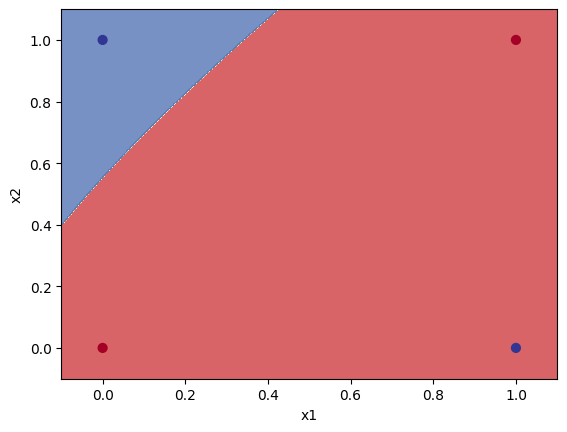

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.7500 - loss: 0.5760
Epoch 1701/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7500 - loss: 0.5759
Epoch 1702/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7500 - loss: 0.5758
Epoch 1703/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7500 - loss: 0.5756
Epoch 1704/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7500 - loss: 0.5755
Epoch 1705/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7500 - loss: 0.5754
Epoch 1706/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7500 - loss: 0.5753
Epoch 1707/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7500 - loss: 0.5752
Epoch 1708/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7500 - loss: 0.5751
Epoch 1709/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7500 - loss: 0.5750
Epoch 1710/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7500 - loss: 0.5749
Epoch 1711/10000
1/1 ━━━━━━━━━━━━━━━━

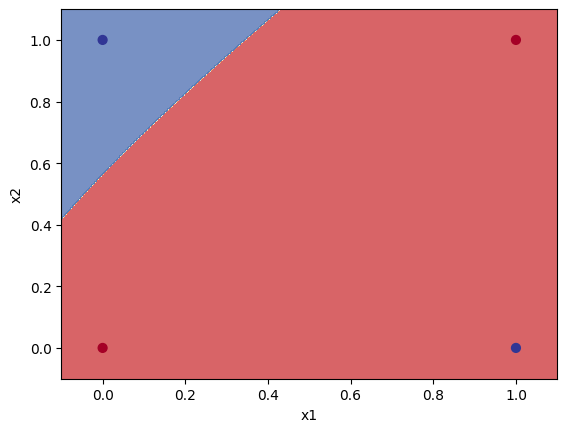

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - accuracy: 0.7500 - loss: 0.5643
Epoch 1801/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7500 - loss: 0.5642
Epoch 1802/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7500 - loss: 0.5640
Epoch 1803/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7500 - loss: 0.5639
Epoch 1804/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7500 - loss: 0.5638
Epoch 1805/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7500 - loss: 0.5637
Epoch 1806/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7500 - loss: 0.5636
Epoch 1807/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7500 - loss: 0.5634
Epoch 1808/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7500 - loss: 0.5633
Epoch 1809/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7500 - loss: 0.5632
Epoch 1810/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7500 - loss: 0.5631
Epoch 1811/10000
1/1 ━━━━━━━━━━━━━━━━

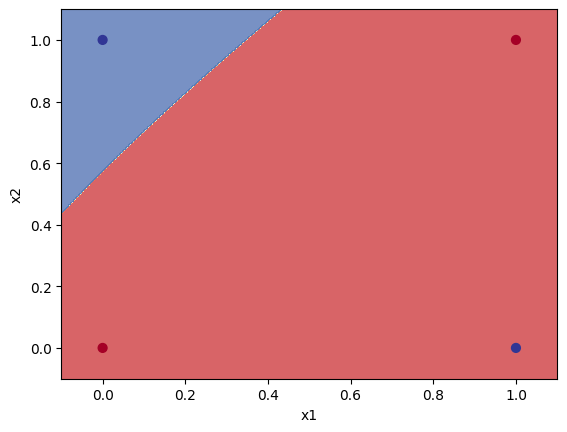

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - accuracy: 0.7500 - loss: 0.5518
Epoch 1901/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7500 - loss: 0.5517
Epoch 1902/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7500 - loss: 0.5515
Epoch 1903/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7500 - loss: 0.5514
Epoch 1904/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7500 - loss: 0.5513
Epoch 1905/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7500 - loss: 0.5511
Epoch 1906/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7500 - loss: 0.5510
Epoch 1907/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7500 - loss: 0.5509
Epoch 1908/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7500 - loss: 0.5508
Epoch 1909/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7500 - loss: 0.5506
Epoch 1910/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7500 - loss: 0.5505
Epoch 1911/10000
1/1 ━━━━━━━━━━━━━━━━

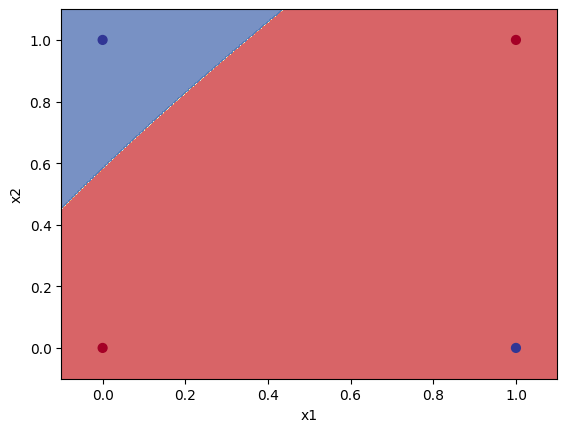

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - accuracy: 0.7500 - loss: 0.5385
Epoch 2001/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7500 - loss: 0.5384
Epoch 2002/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7500 - loss: 0.5383
Epoch 2003/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7500 - loss: 0.5381
Epoch 2004/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7500 - loss: 0.5380
Epoch 2005/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7500 - loss: 0.5378
Epoch 2006/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7500 - loss: 0.5377
Epoch 2007/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7500 - loss: 0.5376
Epoch 2008/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7500 - loss: 0.5374
Epoch 2009/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7500 - loss: 0.5373
Epoch 2010/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7500 - loss: 0.5372
Epoch 2011/10000
1/1 ━━━━━━━━━━━━━━━━

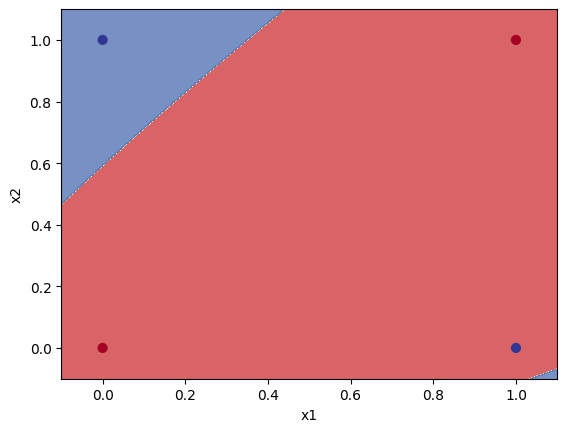

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - accuracy: 0.7500 - loss: 0.5245
Epoch 2101/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7500 - loss: 0.5243
Epoch 2102/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7500 - loss: 0.5242
Epoch 2103/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7500 - loss: 0.5241
Epoch 2104/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7500 - loss: 0.5239
Epoch 2105/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7500 - loss: 0.5238
Epoch 2106/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7500 - loss: 0.5236
Epoch 2107/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7500 - loss: 0.5235
Epoch 2108/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.7500 - loss: 0.5233
Epoch 2109/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.7500 - loss: 0.5232
Epoch 2110/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7500 - loss: 0.5230
Epoch 2111/10000
1/1 ━━━━━━━━━━━━━━━━

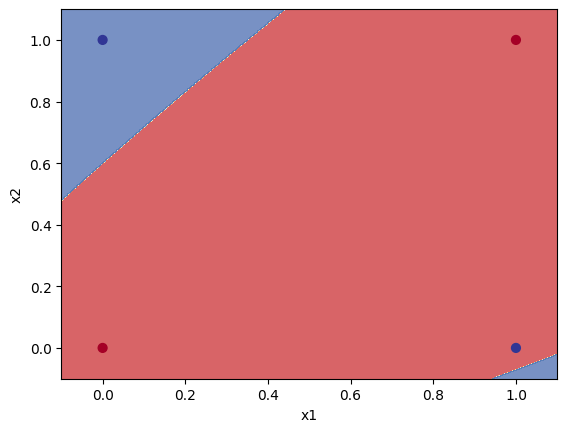

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - accuracy: 0.7500 - loss: 0.5097
Epoch 2201/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7500 - loss: 0.5096
Epoch 2202/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7500 - loss: 0.5094
Epoch 2203/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7500 - loss: 0.5093
Epoch 2204/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7500 - loss: 0.5091
Epoch 2205/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7500 - loss: 0.5090
Epoch 2206/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7500 - loss: 0.5088
Epoch 2207/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7500 - loss: 0.5087
Epoch 2208/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7500 - loss: 0.5085
Epoch 2209/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7500 - loss: 0.5084
Epoch 2210/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7500 - loss: 0.5082
Epoch 2211/10000
1/1 ━━━━━━━━━━━━━━━━

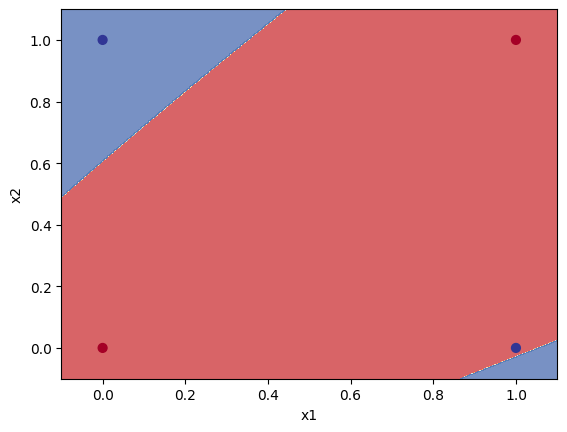

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - accuracy: 0.7500 - loss: 0.4943
Epoch 2301/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7500 - loss: 0.4941
Epoch 2302/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7500 - loss: 0.4940
Epoch 2303/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7500 - loss: 0.4938
Epoch 2304/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7500 - loss: 0.4936
Epoch 2305/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7500 - loss: 0.4935
Epoch 2306/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7500 - loss: 0.4933
Epoch 2307/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7500 - loss: 0.4932
Epoch 2308/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7500 - loss: 0.4930
Epoch 2309/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7500 - loss: 0.4929
Epoch 2310/10000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7500 - loss: 0.4927
Epoch 2311/10000
1/1 ━━━━━━━━━━━━━━━━

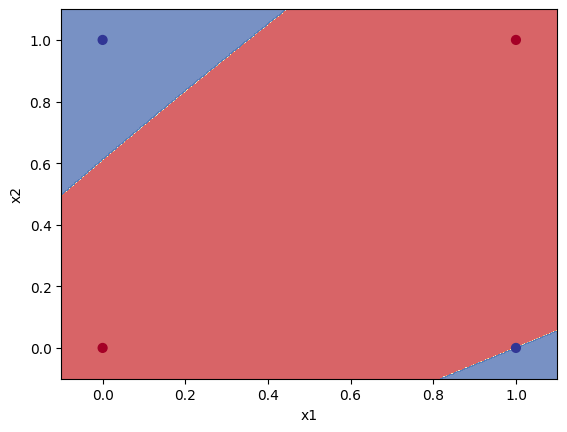

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - accuracy: 1.0000 - loss: 0.4826


In [67]:
model = trainModel(X, Y) # вызов обучения модели

In [68]:
input_data = np.array([[0, 1]])
testModel(input_data, model) # вызов тестирования обученной модели на тестовых данных

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
[[0.6592046]]


1

In [69]:
# Получить веса нейрона
model.get_weights()

[array([[-0.82614464,  1.50599   ],
        [ 1.424797  , -1.5131271 ]], dtype=float32),
 array([0.19913888, 0.93520683], dtype=float32),
 array([[-1.1031725],
        [-1.5226549]], dtype=float32),
 array([0.8868645], dtype=float32)]